In [36]:
# GENERAL IMPORTS

import torch
from mapping.datasets import RLDatasetFormatter
from mapping.models import Discriminator, TransitionModel, LitAutoEncoder

In [37]:
# READING OF DATASETS

dataset_t_path = 'data/UntrainedMCDataset500.csv'
dataset_s_path = 'data/UntrainedPendDataset5000.csv'
extended_dataset_t_path = 'data/UntrainedMCDataset5000.csv'

data_formatter_t = RLDatasetFormatter().from_csv(dataset_t_path)
data_formatter_s = RLDatasetFormatter().from_csv(dataset_s_path)
ext_data_formatter_t = RLDatasetFormatter().from_csv(extended_dataset_t_path)

In [38]:
# TRAINING OF DISCRIMINATOR


def generate_synthetic_dataset(n, s_bound, a_bound):

    fake_s, fake_s1, fake_a = [], [], []

    for r0, r1 in s_bound:
        fake_s.append((r1-r0)*torch.rand((n, 1)) + r0)
    fake_s = torch.cat(fake_s, 1)

    for r0, r1 in a_bound:
        fake_a.append((r1-r0)*torch.rand((n, 1)) + r0)
    fake_a = torch.cat(fake_a, 1)

    for r0, r1 in s_bound:
        fake_s1.append((r1-r0)*torch.rand((n, 1)) + r0)
    fake_s1 = torch.cat(fake_s1, 1)
    fake_r = torch.zeros((n, 1))

    return RLDatasetFormatter([fake_s, fake_a, fake_r, fake_s1]).transition_as_fake()


disc_dataset = data_formatter_t.transition_as_valid()

fake_samples = [
    {
        'count': len(disc_dataset)//2,
        's_bound': [(-1.2, 0.6), (-0.07, 0.07)],
        'a_bound': [(-1, 1)]
    },
    {
        'count': len(disc_dataset)//2,
        's_bound': [(-12, 6), (-0.7, 0.7)],
        'a_bound': [(-10, 10)]
    },
    {
        'count': len(disc_dataset)//2,
        's_bound': [(-120, 60), (-7, 7)],
        'a_bound': [(-100, 100)]
    }]

for desc in fake_samples:
    sd = generate_synthetic_dataset(desc['count'], desc['s_bound'], desc['a_bound'])
    disc_dataset = disc_dataset.merge(sd)


D = Discriminator(data_formatter_t.state_size, data_formatter_t.action_size)
D.train_model(disc_dataset, model_dir='/Discriminator', batch_size=20)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 6:  31%|███▏      | 20/64 [00:00<00:00, 140.79it/s, loss=0.04, v_num=1]  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
dataset_t = data_formatter_t.as_transitions()

T = TransitionModel(data_formatter_t.state_size, data_formatter_t.action_size)
T.train_model(dataset_t, model_dir='/T')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/T/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.5 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 136.81it/s, loss=0.00286, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 130.91it/s, loss=0.00286, v_num=0]


In [ ]:
D_model_checkpoint = 'lightning_logs/Discriminator/lightning_logs/version_0/checkpoints/epoch=99-step=5700.ckpt'
T_model_checkpoint = 'lightning_logs/T/lightning_logs/version_0/checkpoints/epoch=99-step=2300.ckpt'

T = TransitionModel.load_from_checkpoint(T_model_checkpoint, s_dim=data_formatter_t.state_size, a_dim=data_formatter_t.action_size)
D = Discriminator.load_from_checkpoint(D_model_checkpoint, s_dim=data_formatter_t.state_size, a_dim=data_formatter_t.action_size)

source_triplet_size = data_formatter_s.state_size*2+data_formatter_s.action_size
AE = LitAutoEncoder(T, D, dim_s=source_triplet_size)

dataset_s = data_formatter_s.transition_identity()
AE.train_model(dataset_s, batch_size=100, model_dir="/AE")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/AE/lightning_logs

  | Name    | Type            | Params
--------------------------------------------
0 | D       | Discriminator   | 50.2 K
1 | T       | TransitionModel | 33.5 K
2 | encoder | Sequential      | 837   
3 | decoder | Sequential      | 839   
--------------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 65.54it/s, loss=0.0242, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 64.34it/s, loss=0.0242, v_num=0]


In [ ]:
M = AE.encoder
M_inv = AE.decoder

dataset_s = data_formatter_s.transition_identity()

sas, _ = dataset_s[:]
synthetic_data = M(sas)
r_synth = torch.zeros((synthetic_data.shape[0],1))
s_synth,a_synth,s1_synth = torch.split(synthetic_data, [data_formatter_t.state_size, data_formatter_t.action_size, data_formatter_t.state_size],1)
data_formatter_synth = RLDatasetFormatter([s_synth, a_synth, r_synth, s1_synth])

In [ ]:
dataset_synth = data_formatter_synth.as_transitions()
dataset_t = data_formatter_t.as_transitions().merge(dataset_synth)
T_hat = TransitionModel(data_formatter_t.state_size, data_formatter_t.action_size)
T_hat.train_model(dataset_t, model_dir='/T_hat')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/T_hat/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.5 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:262: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  "Could not log computational graph to TensorBoard: The `model.example_input_array` attri

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 99: 100%|██████████| 276/276 [00:02<00:00, 106.34it/s, loss=0.0124, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 276/276 [00:02<00:00, 105.98it/s, loss=0.0124, v_num=0]


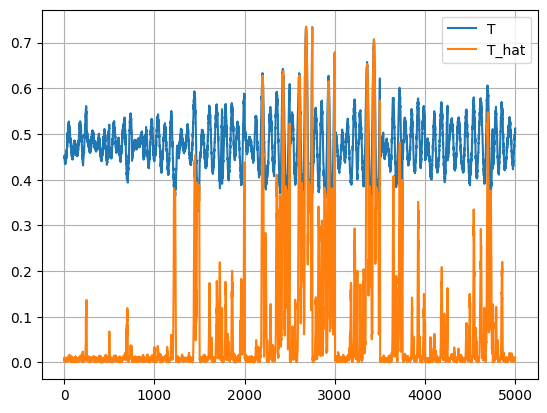

In [ ]:
ext_dataset_t = ext_data_formatter_t.as_transitions()

sa, s1 = ext_dataset_t[:]

import matplotlib.pyplot as plt

error = T(sa)-s1
plt.plot(torch.norm(error,dim=1,).detach().numpy())
error = T_hat(sa)-s1
plt.plot(torch.norm(error,dim=1).detach().numpy())
plt.legend(['T', 'T_hat'])
plt.grid()